In [913]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [914]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, recall_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline

In [915]:
class testing_model:
	def ensure_nasdaq(self, df):
		##check headdings are correct: Date, Open, Close/Last, High, Low, Volume
		try:
			if 'Date' not in df.columns:
				raise ValueError("The data does not contain the 'Date' column. Columns are: ", df.columns.tolist())

			if 'Open' not in df.columns:
				raise ValueError("The data does not contain the 'Open' column. Columns are: ", df.columns.tolist())
			
			if 'Close/Last' not in df.columns:
				raise ValueError("The data does not contain the 'Close/Last' column. Columns are: ", df.columns.tolist())
				
			if 'High' not in df.columns:
				raise ValueError("The data does not contain the 'High' column. Columns are: ", df.columns.tolist())
			
			if 'Low' not in df.columns:
				raise ValueError("The data does not contain the 'Low' column. Columns are: ", df.columns.tolist())

			if 'Volume' not in df.columns:
				raise ValueError("The data does not contain the 'Volume' column. Columns are: ", df.columns.tolist())
			
		except Exception as e:
			print("Error:	", e)
			print("Data is not in the correct format. Please provide data from nasdaq.com")
			return False
		
		finally:
			print("Data is in the correct format and likely origins from nasdaq.com")
			return True

	def translate_data(self, path):
		data = pd.read_csv(path)
		# Ensure that the data is from nasdaq.com
	
		if(not self.ensure_nasdaq(data)):
			raise ValueError("The data is not from nasdaq.com. Please provide data from nasdaq.com")
			return None

		# Translate the data and remove $ from the data and multiply close, open, high and low by a factor of 100 and convert them to integers
		data['Date'] = pd.to_datetime(data['Date'])
		data['Close/Last'] = data['Close/Last'].replace('[\$,]', '', regex=True).astype(float)
		data['Open'] = data['Open'].replace('[\$,]', '', regex=True).astype(float)
		data['High'] = data['High'].replace('[\$,]', '', regex=True).astype(float)
		data['Low'] = data['Low'].replace('[\$,]', '', regex=True).astype(float)


		# inverse the entire dataframe
		data = data.iloc[::-1]
		return data

	def build_training(self, origindf, column, lag=5, drop=True):
		lags = lag
		names = []

		df = origindf.copy()

		for i in range(1, lags+1):
			df[f'{column}_{i}'] = df[column].shift(i)

			names.append(f'{column}_{i}')

		if drop:
			df.dropna(inplace=True)

		return df, names
	
	def prepare_data(self, raw_data, lag=2):

		## create the dataframe
		training_data = pd.DataFrame()

		## Add the known data to the dataframe
		training_data['Date'] = raw_data['Date']
		training_data['Open'] = raw_data['Open']
		training_data['Close'] = raw_data['Close/Last']

		## Add the inferred data to the dataframe
		training_data['Diff'] = raw_data['Close/Last'] - raw_data['Close/Last'].shift(1)
		training_data['Dir'] = np.where(training_data['Diff'] > 0, 1, -1)

		## build the lagged data
		training_data, close_lags = self.build_training(training_data, 'Close', lag=2, drop=False)
		training_data, open_lags = self.build_training(training_data, 'Open', lag=2, drop=False)
		training_data, diff_lags = self.build_training(training_data, 'Diff', lag=2, drop=True)

		## shift the direction column
		temp = training_data['Dir'].iloc[0]
		training_data['Dir'] = training_data['Dir'].shift(-1)
		training_data.loc[training_data.index[-1], 'Dir'] = temp


		## reset the index
		training_data = training_data.reset_index(drop=True)

		## add the constant
		training_data['Constant'] = 1.0

		return training_data, {'Close': close_lags, 'Open': open_lags, 'Diff': diff_lags}

	def split(self, data, complexity, verbose):
		self.open_close = data[['Date'] + self.searchwith['Open'] + self.searchwith['Close']]
		self.direction 	= data[['Date'] + self.searchwith['Diff'] + self.searchfor['Diff']]

		#--/-=======================================================================================================
		##/		Train Data	|	open_close	65%
		#{<			Split	|					-> varying number of rows used to account for respective fitting
		##\					|	direction	20%
		#--\-=======================================================================================================
		self.open_close_train 	= self.open_close.iloc	[:int(len(self.open_close)*0.65)]

		if complexity == 1:
			self.direction_train 	= self.direction.iloc	[:int(len(self.direction)*0.20)]
		
		if complexity == 2:
			self.direction_train 	= self.direction.iloc	[int(len(self.open_close)*0.35):int(len(self.open_close)*0.45)]

		if complexity == 3:
			self.direction_train 	= self.direction.iloc	[int(len(self.open_close)*0.55):int(len(self.open_close)*0.65)]

		if complexity == 4:
			self.direction_train 	= self.direction.iloc	[:int(len(self.open_close)*0.65)]


		#--/-=======================================================================================================
		##/		Test Data	|	open_close	35%
		#{<			Split	|					-> same number of rows used to allow for comparison
		##\					|	direction	35%
		#--\-=======================================================================================================
		self.open_close_test 	= self.open_close.iloc	[int(len(self.open_close)*0.65):]
		self.direction_test 	= self.direction.iloc	[int(len(self.direction)*0.65):]

		if verbose:
			print("\nColumns in Open/Close:		", self.open_close.columns.tolist())
			print("Columns in Direction:		", self.direction.columns.tolist())

			print("\nTraining: \nClose/Open Shapes:	", self.open_close_train.shape, "Direction: ", self.direction_train.shape)
			print("\nTesting: \nClose/Open Shapes:	", self.open_close_test.shape, "Direction: ", self.direction_test.shape)

		#--/-=======================================================================================================
		##/					|	Ensuring the data
		#{<	Sanity Checks	|	is ready for training
		##\					|	and built correctly
		#--\-=======================================================================================================
  
		try:
			if not len(self.open_close_train) or not len(self.direction_train):
				raise ValueError("Training data is empty. Please provide more data.")
			
			if not len(self.open_close_test) or not len(self.direction_test):
				raise ValueError("Testing data is empty. Please provide more data.")
			
			if not len(self.open_close_test) == len(self.direction_test):
				raise ValueError("Testing data is not the same length. Please see configuation, predictions may not work as intended.")
		except Exception as e:
			print("Error:	", e)
			print("Data is not ready for training.")

		finally:
			print("\n\nData is ready for training.")

	def __init__(self, end_classifier, open_classifier, direction_classifer, filepath, complexity=1, years=4, verbose=False):

		## set classifiers
		self.end_classifier 		= end_classifier
		self.open_classifier 		= open_classifier
		self.direction_classifier 	= direction_classifer

		## get filename from path
		self.filename = filepath.split('/')[-1].split('.')[0]

		## read in raw data
		raw_data = self.translate_data(filepath)

		## get the last x years of data
		raw_data = raw_data[raw_data['Date'] > pd.to_datetime('today') - pd.DateOffset(years=years)]
		## reset the index
		raw_data = raw_data.reset_index(drop=True)
		
		## prepare the data for splitting
		data, self.lags = self.prepare_data(raw_data, lag=2)

		## Setup easy access to needed columns
		self.searchwith = {
			'Close': ['Open'] + self.lags['Close'],
			'Open': ['Close'] + self.lags['Open'],
			'Diff': ['Diff'] + self.lags['Diff']
		}

		self.searchfor = {
			'Close': ['Close'],
			'Open': ['Open'],
			'Diff': ['Dir']
		}

		## split the data
		self.split(data, complexity, verbose=verbose)

	def train(self):
		#--/-=======================================================================================================
		##/					|	Training the models
		#{<	Training		|	the models
		##\					|	
		#--\-=======================================================================================================
  
		try:
			self.end_classifier.fit(		self.open_close_train[self.searchwith['Close']], 	self.open_close_train[self.searchfor['Close']])
			self.open_classifier.fit(		self.open_close_train[self.searchwith['Open']].drop(len(self.open_close_train)-1), 	self.open_close_train[self.searchfor['Open']].shift(-1).dropna())
			self.direction_classifier.fit(	self.direction_train[self.searchwith['Diff']], 		self.direction_train[self.searchfor['Diff']])
		except Exception as e:
			print("Error:	", e)
			return "Models have not been trained."

		finally:
			return "Models have been trained."

	def create_lags(self, df, column, lags=5):
		
		lag = lags
		names = []

		for i in range(1, lag+1):
			df[f'{column}_{i}'] = []
			names.append(f'{column}_{i}')

		return names
	
	def build_predicted_lags(self, df, column, row, lags):
		if row > lags:
			for i in range(1, lags+1):
				df.loc[row, f'{column}_{i}'] = df[f'{column}'].iloc[row-i]

		else:
			for i in range(1, lags+1):

				if i <= row:
					df.loc[row, f'{column}_{i}'] = df[f'{column}'].iloc[row-i]
				else:
					df.loc[row, f'{column}_{i}'] = df.loc[row-1, f'{column}_{i-1}']

	def build_lags(self, df, column, buffer,row=0, lags=5, verbose=False):

		if verbose:
			print("building row: ", row, " for column: ", column)

		if row == 0:
			for i in range(1, lags+1):
				df.loc[row, f'{column}_{i}'] = buffer[(lags-i)]

		else:
			self.build_predicted_lags(df, column, row, lags)

		return df

	def setup_dataframe(self, lag):

		test_predictions = pd.DataFrame()

		lagbuffers = {
			'Close': self.open_close_train['Open'][len(self.open_close_train)-lag:].reset_index(drop=True),
			'Open': self.open_close_train['Close'][len(self.open_close_train)-lag:].reset_index(drop=True),
			'Diff': self.direction_train['Diff'][len(self.direction_train)-lag:].reset_index(drop=True)
		}


		test_predictions['Date'] = pd.to_datetime([])
		test_predictions['Open'] = []
		open_names = self.create_lags(test_predictions, 'Open', lags=lag)
		test_predictions['Close'] = []
		close_names = self.create_lags(test_predictions, 'Close', lags=lag)
		test_predictions['Diff'] = []
		diff_names = self.create_lags(test_predictions, 'Diff', lags=lag)
		test_predictions['Dir'] = []

		test_predictions.loc[0, 'Date'] = self.open_close_train['Date'].iloc[-1] + pd.DateOffset(days=1)

		return test_predictions, lagbuffers

	def setup_firstrun(self, test_predictions, lagbuffers, lag, verbose):

		## get the last row of the training data to predict the first row of the test data
		last_row = self.open_close_train.iloc[-1].to_frame().T.reset_index(drop=True)

		test_predictions.loc[0, 'Open'] = self.open_classifier.predict(last_row[self.searchwith['Open']])[-1]

		self.build_lags(test_predictions, 'Open', lagbuffers['Open'], row=0, lags=lag, verbose=verbose)
		self.build_lags(test_predictions, 'Close', lagbuffers['Close'], row=0, lags=lag, verbose=verbose)

		test_predictions.loc[0, 'Close'] = self.end_classifier.predict(test_predictions[self.searchwith['Close']].iloc[0].to_frame().T)[-1]

		test_predictions.loc[0, 'Diff'] = test_predictions.loc[0, 'Close'] - test_predictions.loc[0, 'Close_1']

		self.build_lags(test_predictions, 'Diff', lagbuffers['Diff'], row=0, lags=lag)

		test_predictions.loc[0, 'Dir'] = self.direction_classifier.predict(test_predictions[self.searchwith['Diff']].iloc[0].to_frame().T)[-1]

		return test_predictions
	
	def run_days(self, test_predictions, lagbuffers, lag, days, verbose):
		for i in range(1, days):
			
			test_predictions.loc[i, 'Date'] = test_predictions.loc[i-1, 'Date'] + pd.DateOffset(days=1)

			last_row = test_predictions.iloc[i-1].to_frame().T.reset_index(drop=True)

			test_predictions.loc[i, 'Open'] = self.open_classifier.predict(last_row[self.searchwith['Open']])[-1]

			self.build_lags(test_predictions, 'Open', lagbuffers['Open'], row=i, lags=lag, verbose=verbose)
			self.build_lags(test_predictions, 'Close', lagbuffers['Close'], row=i, lags=lag, verbose=verbose)

			test_predictions.loc[i, 'Close'] = self.end_classifier.predict(test_predictions[self.searchwith['Close']].iloc[i].to_frame().T)[-1]
		
			test_predictions.loc[i, 'Diff'] = test_predictions.loc[i, 'Close'] - test_predictions.loc[i, 'Close_1']

			self.build_lags(test_predictions, 'Diff', lagbuffers['Diff'], row=i, lags=lag)

			test_predictions.loc[i, 'Dir'] = self.direction_classifier.predict(test_predictions[self.searchwith['Diff']].iloc[i].to_frame().T)[-1]

		if verbose:
			print(test_predictions)
		self.test_predictions = test_predictions


	def test(self, lag=2, days=None, verbose=False):
		#--/-=======================================================================================================
		##/					|	Testing the models
		#{<	Testing			|	the models
		##\					|	
		#--\-=======================================================================================================
		self.open_close_test['pred_Close'] 	= self.end_classifier.predict(		self.open_close_test[self.searchwith['Close']])
		self.open_close_test['pred_Open'] 	= self.open_classifier.predict(		self.open_close_test[self.searchwith['Open']])
		self.direction_test['pred_Dir'] 	= self.direction_classifier.predict(self.direction_test[self.searchwith['Diff']])

		try:
			test_predictions, lagbuffers = self.setup_dataframe(lag)

			test_predictions = self.setup_firstrun(test_predictions, lagbuffers, lag, verbose=verbose)

			if days:
				self.run_days(test_predictions, lagbuffers, lag, days=days, verbose=verbose)
			else:
				self.run_days(test_predictions, lagbuffers, lag, days=len(self.open_close_test), verbose=verbose)

			if verbose:
				print(self.open_close_test, self.direction_test)
		except Exception as e:
			print("Error:	", e)
			return "Models have not been tested."
		
		finally:
			return "Models have been tested."
	
	def plot_train(self):
		#--/-=======================================================================================================
		##/					|	Plotting the data
		#{<	Plotting		|	the data
		##\					|	
		#--\-=======================================================================================================
		fig, ax = plt.subplots(2, figsize=(25, 10))

		ax[0].plot(self.open_close_train['Date'], self.open_close_train['Close'], label='Close', color='red')
		ax[0].plot(self.open_close_train['Date'], self.open_close_train['Open'], label='Open', color='blue')
		ax[0].set_title("Close and Open Training Data")
		ax[0].legend()

		ax[1].plot(self.direction_train['Date'], self.direction_train['Dir'].cumsum(), label='Direction', color='green')
		ax[1].set_title("Direction Training Data")
		ax[1].legend()

		plt.show()
	
	def plot_test(self):
		#--/-=======================================================================================================
		##/					|	Plotting the data
		#{<	Plotting		|	the data
		##\					|	
		#--\-=======================================================================================================
		fig, ax = plt.subplots(4, figsize=(25, 20))




		## Daily graph
		ax[0].plot(self.open_close_test['Date'], self.open_close_test['Open'], label='Open', color='blue')
		ax[0].plot(self.open_close_test['Date'], self.open_close_test['Close'], label='Close', color='red')
		ax[0].plot(self.open_close_test['Date'], self.open_close_test['pred_Open'], label='Predicted Open', color='green', linestyle='--')
		ax[0].plot(self.open_close_test['Date'], self.open_close_test['pred_Close'], label='Predicted Close', color='yellow', linestyle='--')
		ax[0].set_title("Close and Open Price Predictions from previous day's data")
		ax[0].legend()


		ax[1].plot(self.open_close_test['Date'], self.open_close_test['Open'], label='Open Price', color='blue')
		ax[1].plot(self.open_close_test['Date'], self.test_predictions['Open'], label='Predicted Open Trend', color='green', linestyle='-.')
		ax[1].plot(self.open_close_test['Date'], self.test_predictions['Close'], label='Predicted Close Trend', color='yellow', linestyle='-.')
		ax[1].set_title("Open and Close Trend Predictions for Whole Test Data")
		ax[1].legend()


		self.direction_test['pred_strat'] = self.direction_test['pred_Dir'] * self.direction_test['Dir']
		self.direction_test['pred_return'] = self.direction_test['pred_strat'] * self.direction_test['Diff']
		## add the first value in the test data to the first value in the predictions
		self.direction_test.loc[self.direction_test.index[0], 'pred_return'] += self.open_close_test.loc[self.open_close_test.index[0], 'Open']

		ax[2].plot(self.direction_test['Date'], self.direction_test['pred_return'].cumsum(), label='Holding\'s Growth', color='yellow', linestyle='-.')
		ax[2].plot(self.open_close_test['Date'], self.open_close_test['Open'], label='Open Price', color='blue')
		ax[2].set_title("Predicted Profits for Whole Test Data")
		ax[2].legend()


		ax[3].plot(self.direction_test['Date'][:30], self.direction_test['Dir'][:30].cumsum(), label='Direction', color='green')
		ax[3].plot(self.direction_test['Date'][:30], self.direction_test['pred_Dir'][:30].cumsum(), label='Predicted Direction', color='blue', linestyle='--')
		ax[3].plot(self.direction_test['Date'][:30], self.test_predictions['Dir'][:30].cumsum(), label='Predicted Direction Trend', linestyle='-.', color='yellow')
		ax[3].set_title("Direction Predictions for first month of Test Data")
		ax[3].legend()

		plt.show()

	def show_confusion_matrix(self, cm, title, fig=None, ax=None):
		## create the heatmap of the confusion matrix
		sns.heatmap(cm, ax=ax, annot=True, fmt='g', cmap='cividis', cbar=True)

	## configurations for the plot when not part of a subplot
		if(fig == None):

			### Set the title of the plot
			plt.title('CONFUSION MATRIX FOR THE ' + title + ' MODEL')

			### Add Labels for the different cells of the confusion matrix
			plt.text(0.5, 0.5, "\n\nTrue Negative", ha='center', va='center')
			plt.text(1.5, 0.5, "\n\nFalse Positive", ha='center', va='center')
			plt.text(0.5, 1.5, "\n\nFalse Negative", ha='center', va='center')
			plt.text(1.5, 1.5, "\n\nTrue Positive", ha='center', va='center')


			### Set the ticks for the x and y axis
			plt.xticks([0.5, 1.5], ['Negative', 'Positive'])
			plt.yticks([0.5, 1.5], ['Negative', 'Positive'])


			### Set the labels for the x and y axis
			plt.ylabel('Actual')
			plt.xlabel('Predicted')

			plt.show()
		else:

		## configurations for the plot when part of a subplot
			ax.set_title('CONFUSION MATRIX FOR THE ' + title + ' MODEL')
			ax.text(0.5, 0.5, "\n\nTrue Negative", ha='center', va='center')
			ax.text(1.5, 0.5, "\n\nFalse Positive", ha='center', va='center')
			ax.text(0.5, 1.5, "\n\nFalse Negative", ha='center', va='center')
			ax.text(1.5, 1.5, "\n\nTrue Positive", ha='center', va='center')

			ax.set_xticks([0.5, 1.5])
			ax.set_xticklabels(['Negative', 'Positive'])
			ax.set_yticks([0.5, 1.5])
			ax.set_yticklabels(['Negative', 'Positive'])

			ax.set_ylabel('Actual')
			ax.set_xlabel('Predicted')

	def evaluate(self):
		#--/-=======================================================================================================
		##/					|	Evaluating the models
		#{<	Evaluating		|	the models
		##\					|	
		#--\-=======================================================================================================
		print("/========================================{", self.filename.upper(), "}========================================\\")
		print("                                    Close Predictions")
		print("----------------------------------------={ "+ (len(self.filename) *"-") + " }=----------------------------------------\n")

		print("	|	Mean Absolute Error:		", mean_absolute_error(	self.open_close_test[self.searchfor['Close']], 	self.test_predictions['Close']), "		|\n")
		print("	|	Mean Squared Error:		", mean_squared_error(	self.open_close_test[self.searchfor['Close']], 	self.test_predictions['Close']), "		|\n")
		print("	|	R2 Score:			", r2_score(	self.open_close_test[self.searchfor['Close']], 	self.test_predictions['Close']), "		|\n")
		print("	|	Rooted Absolute Error:		", math.sqrt(mean_absolute_error(	self.open_close_test[self.searchfor['Close']], 	self.test_predictions['Close'])), "		|\n")
		print("	|	Rooted Mean Squared Error:	", math.sqrt(mean_squared_error(	self.open_close_test[self.searchfor['Close']], 	self.test_predictions['Close'])), "		|\n")
		print("\\========================================{", "END", "}========================================/\n")


		print("/========================================{", self.filename.upper(), "}========================================\\")
		print("                                    Open Predictions")
		print("----------------------------------------={ "+ (len(self.filename) *"-") + " }=----------------------------------------\n")

		print("	|	Mean Absolute Error:		", mean_absolute_error(	self.open_close_test[self.searchfor['Open']], 	self.test_predictions['Open']), "		|\n")
		print("	|	Mean Squared Error:		", mean_squared_error(	self.open_close_test[self.searchfor['Open']], 	self.test_predictions['Open']), "		|\n")
		print("	|	R2 Score:			", r2_score(	self.open_close_test[self.searchfor['Open']], 	self.test_predictions['Open']), "		|\n")
		print("	|	Rooted Absolute Error:		", math.sqrt(mean_absolute_error(	self.open_close_test[self.searchfor['Open']], 	self.test_predictions['Open'])), "		|\n")
		print("	|	Rooted Mean Squared Error:	", math.sqrt(mean_squared_error(	self.open_close_test[self.searchfor['Open']], 	self.test_predictions['Open'])), "		|\n")
		print("\\========================================{", "END", "}=========================================/\n")

		
		print("/========================================{", self.filename.upper(), "}=========================================\\")
		print("                                    Direction Predictions")
		print("----------------------------------------={ "+ (len(self.filename) *"-") + " }=----------------------------------------\n")
		print("Direction Model Report:	\n", classification_report(		self.direction_test[self.searchfor['Diff']], self.direction_test['pred_Dir']))
		print("\n\nDirection Model Recall:	", recall_score(		self.direction_test[self.searchfor['Diff']], self.direction_test['pred_Dir']))
		cm = confusion_matrix(		self.direction_test[self.searchfor['Diff']], self.direction_test['pred_Dir'])
		self.show_confusion_matrix(cm, 'Direction')
		print("\\========================================{", "END", "}=========================================/\n")

		print("/========================================{", self.filename.upper(), "}========================================\\")
		print("                                    Whole Test Predictions")
		print("----------------------------------------={ "+ (len(self.filename) *"-") + " }=----------------------------------------\n")
		print("\n\nWhole Test Predictions:")
		print("Whole Test Prediction Report:	\n", classification_report(		self.direction_test[self.searchfor['Diff']], self.test_predictions['Dir']))
		cm = confusion_matrix(		self.direction_test[self.searchfor['Diff']], self.test_predictions['Dir'])
		self.show_confusion_matrix(cm, 'Direction')
		print("\\========================================{", "END", "}========================================/")


	def calculate_indicators(self, auto=True, verbose=False):
	# When stock price is above the moving average, it's a buy signal
	# When stock price is below the moving average, it's a sell signal
	# EMA's react faster to price changes than SMA's
 
		self.technical_data = pd.DataFrame()
		self.technical_data['SMA_20'] = self.open_close['Close'].rolling(window=20).mean()
		self.technical_data['EMA_20'] = self.open_close['Close'].ewm(span=20, adjust=False).mean()
	# Relative Strength Index (RSI) Implementation
	# RSI values over 70 suggest overbought conditions (potential sell)
	# RSI values under 30 suggest oversold conditions (potential buy)
		delta = self.open_close['Close'].diff()
		gain = (delta.where(delta > 0, 0)).fillna(0)
		loss = (-delta.where(delta < 0, 0)).fillna(0)
	
		avg_gain = gain.rolling(window=14).mean()
		avg_loss = loss.rolling(window=14).mean()
	
		rs = avg_gain / avg_loss
		self.technical_data['RSI'] = 100 - (100 / (1 + rs))
		
	# Moving Average Convergence Divergence (MACD) Implementation
	# Trading signals are generated when the MACD crosses above (buy signal) or below (sell signal) the signal line
	# Above zero is considered bullish (upward trending) market, below zero is considered bearish (downward trending) market
		exp1 = self.open_close['Close'].ewm(span=12, adjust=False).mean()
		exp2 = self.open_close['Close'].ewm(span=26, adjust=False).mean()
		self.technical_data['MACD'] = exp1 - exp2
		self.technical_data['Signal Line'] = self.technical_data['MACD'].ewm(span=9, adjust=False).mean()
		
		if verbose:
			print(self.technical_data.head())
			print(self.technical_data.dtypes)

		if auto:
			self.plot_indicators()

	def plot_indicators(self):
		fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 9), sharex=True)
		
		ax1.plot(self.open_close['Close'], label='Close Price', color='blue')
		ax1.plot(self.technical_data['SMA_20'], label='SMA 20', color='orange')
		ax1.plot(self.technical_data['EMA_20'], label='EMA 20', color='green')
		ax1.set_title('Stock Price with Moving Averages')
		ax1.legend(loc='upper left')
		
		ax2.plot(self.technical_data['RSI'], label='RSI', color='red')
		ax2.set_title('Relative Strength Index')
		ax2.set_ylim(0, 100)	# RSI ranges from 0 to 100
		ax2.axhline(70, color='darkred', linestyle='--')	# Overbought line
		ax2.axhline(30, color='darkgreen', linestyle='--')	# Oversold line
		ax2.legend(loc='upper left')
		
		ax3.plot(self.technical_data['MACD'], label='MACD', color='purple')
		ax3.plot(self.technical_data['Signal Line'], label='Signal Line', color='magenta')
		ax3.set_title('Moving Average Convergence Divergence')
		ax3.legend(loc='upper left')
		
		plt.show()

In [916]:
test = testing_model(
	LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None), 
	LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None), 
	# LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True),
	RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=2,max_features='sqrt', bootstrap=True, oob_score=False, n_jobs=-1, random_state=0, verbose=0, class_weight=None, ccp_alpha=0.025, max_samples=None),
	"csvs/stocks/amd.csv",complexity=4, years=4
)

# tsla: 1/4 3/4
# aapl: 1/5 3/7 3/8
# amd: 1/8

Data is in the correct format and likely origins from nasdaq.com


Data is ready for training.


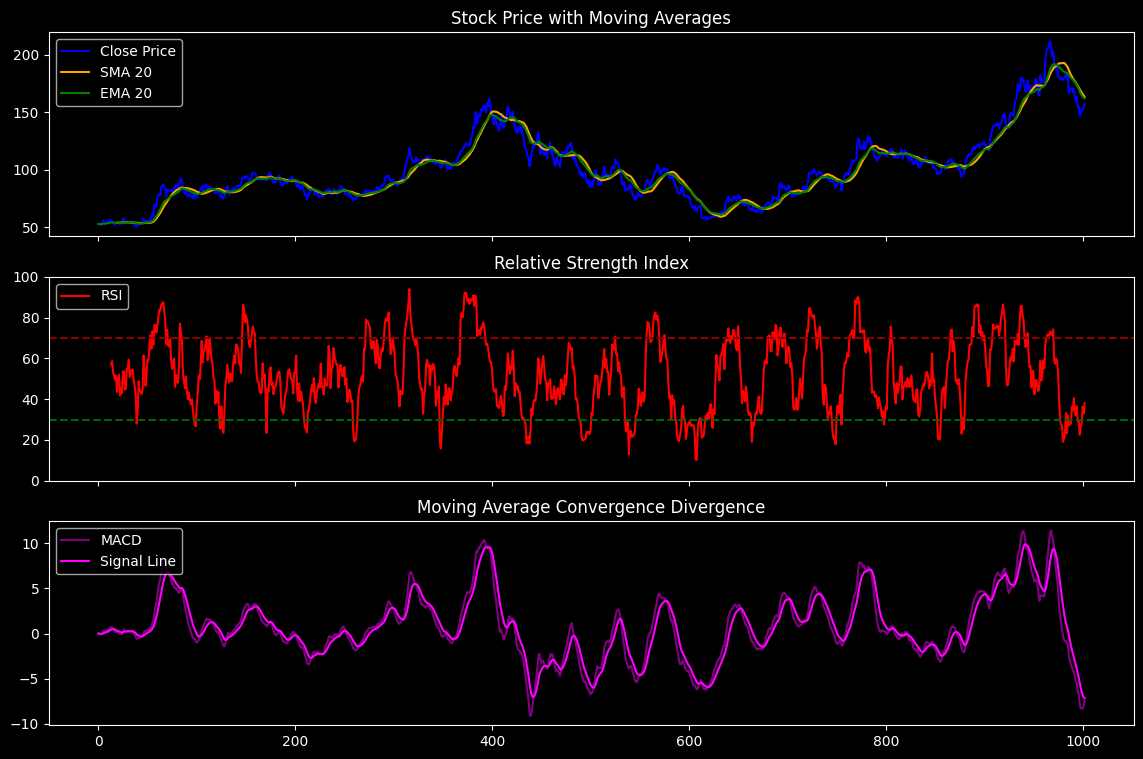

In [917]:
test.calculate_indicators()

In [918]:
test.train()

c:\Development\University\y2\t2\Machine Learning\group rpoject\Group-Project-ML\.venv\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


'Models have been trained.'

In [919]:
test.test()

C:\Users\Spoon\AppData\Local\Temp\ipykernel_37768\852109367.py:330: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.open_close_test['pred_Close'] 	= self.end_classifier.predict(		self.open_close_test[self.searchwith['Close']])
C:\Users\Spoon\AppData\Local\Temp\ipykernel_37768\852109367.py:331: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.open_close_test['pred_Open'] 	= self.open_classifier.predict(		self.open_close_test[self.searchwith['Open']])
C:\Users\Spoon\AppData\Local\Temp\ipykernel_37768\852

'Models have been tested.'

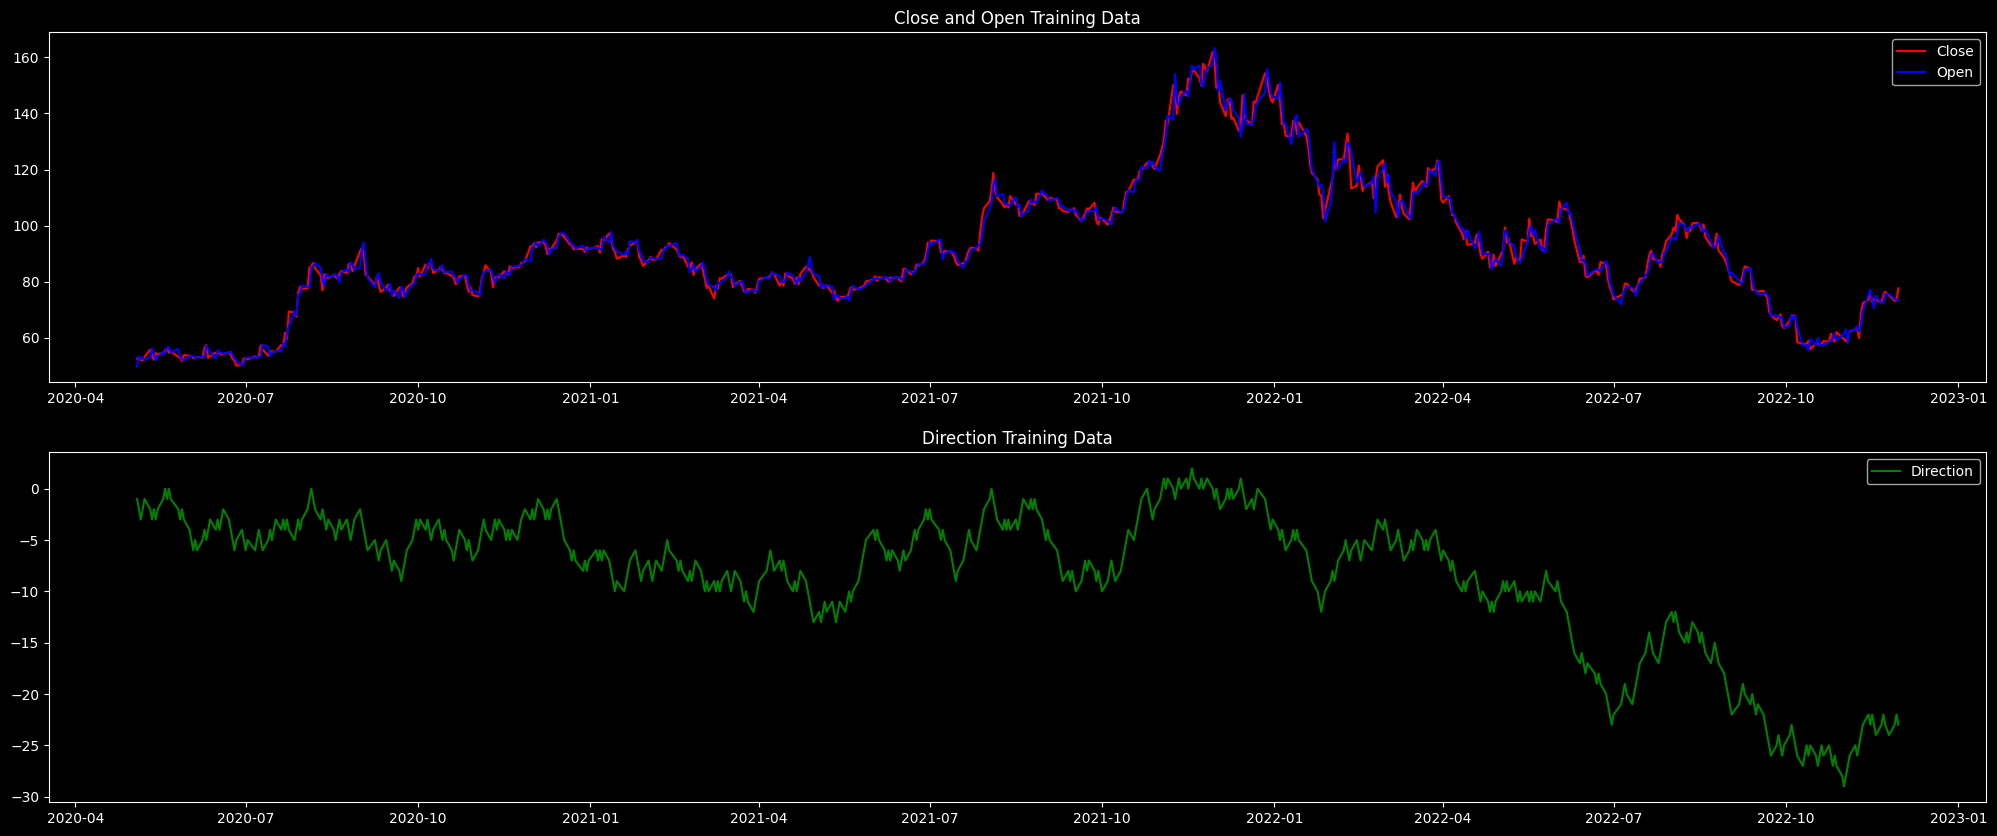

C:\Users\Spoon\AppData\Local\Temp\ipykernel_37768\852109367.py:399: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.direction_test['pred_strat'] = self.direction_test['pred_Dir'] * self.direction_test['Dir']
C:\Users\Spoon\AppData\Local\Temp\ipykernel_37768\852109367.py:400: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.direction_test['pred_return'] = self.direction_test['pred_strat'] * self.direction_test['Diff']


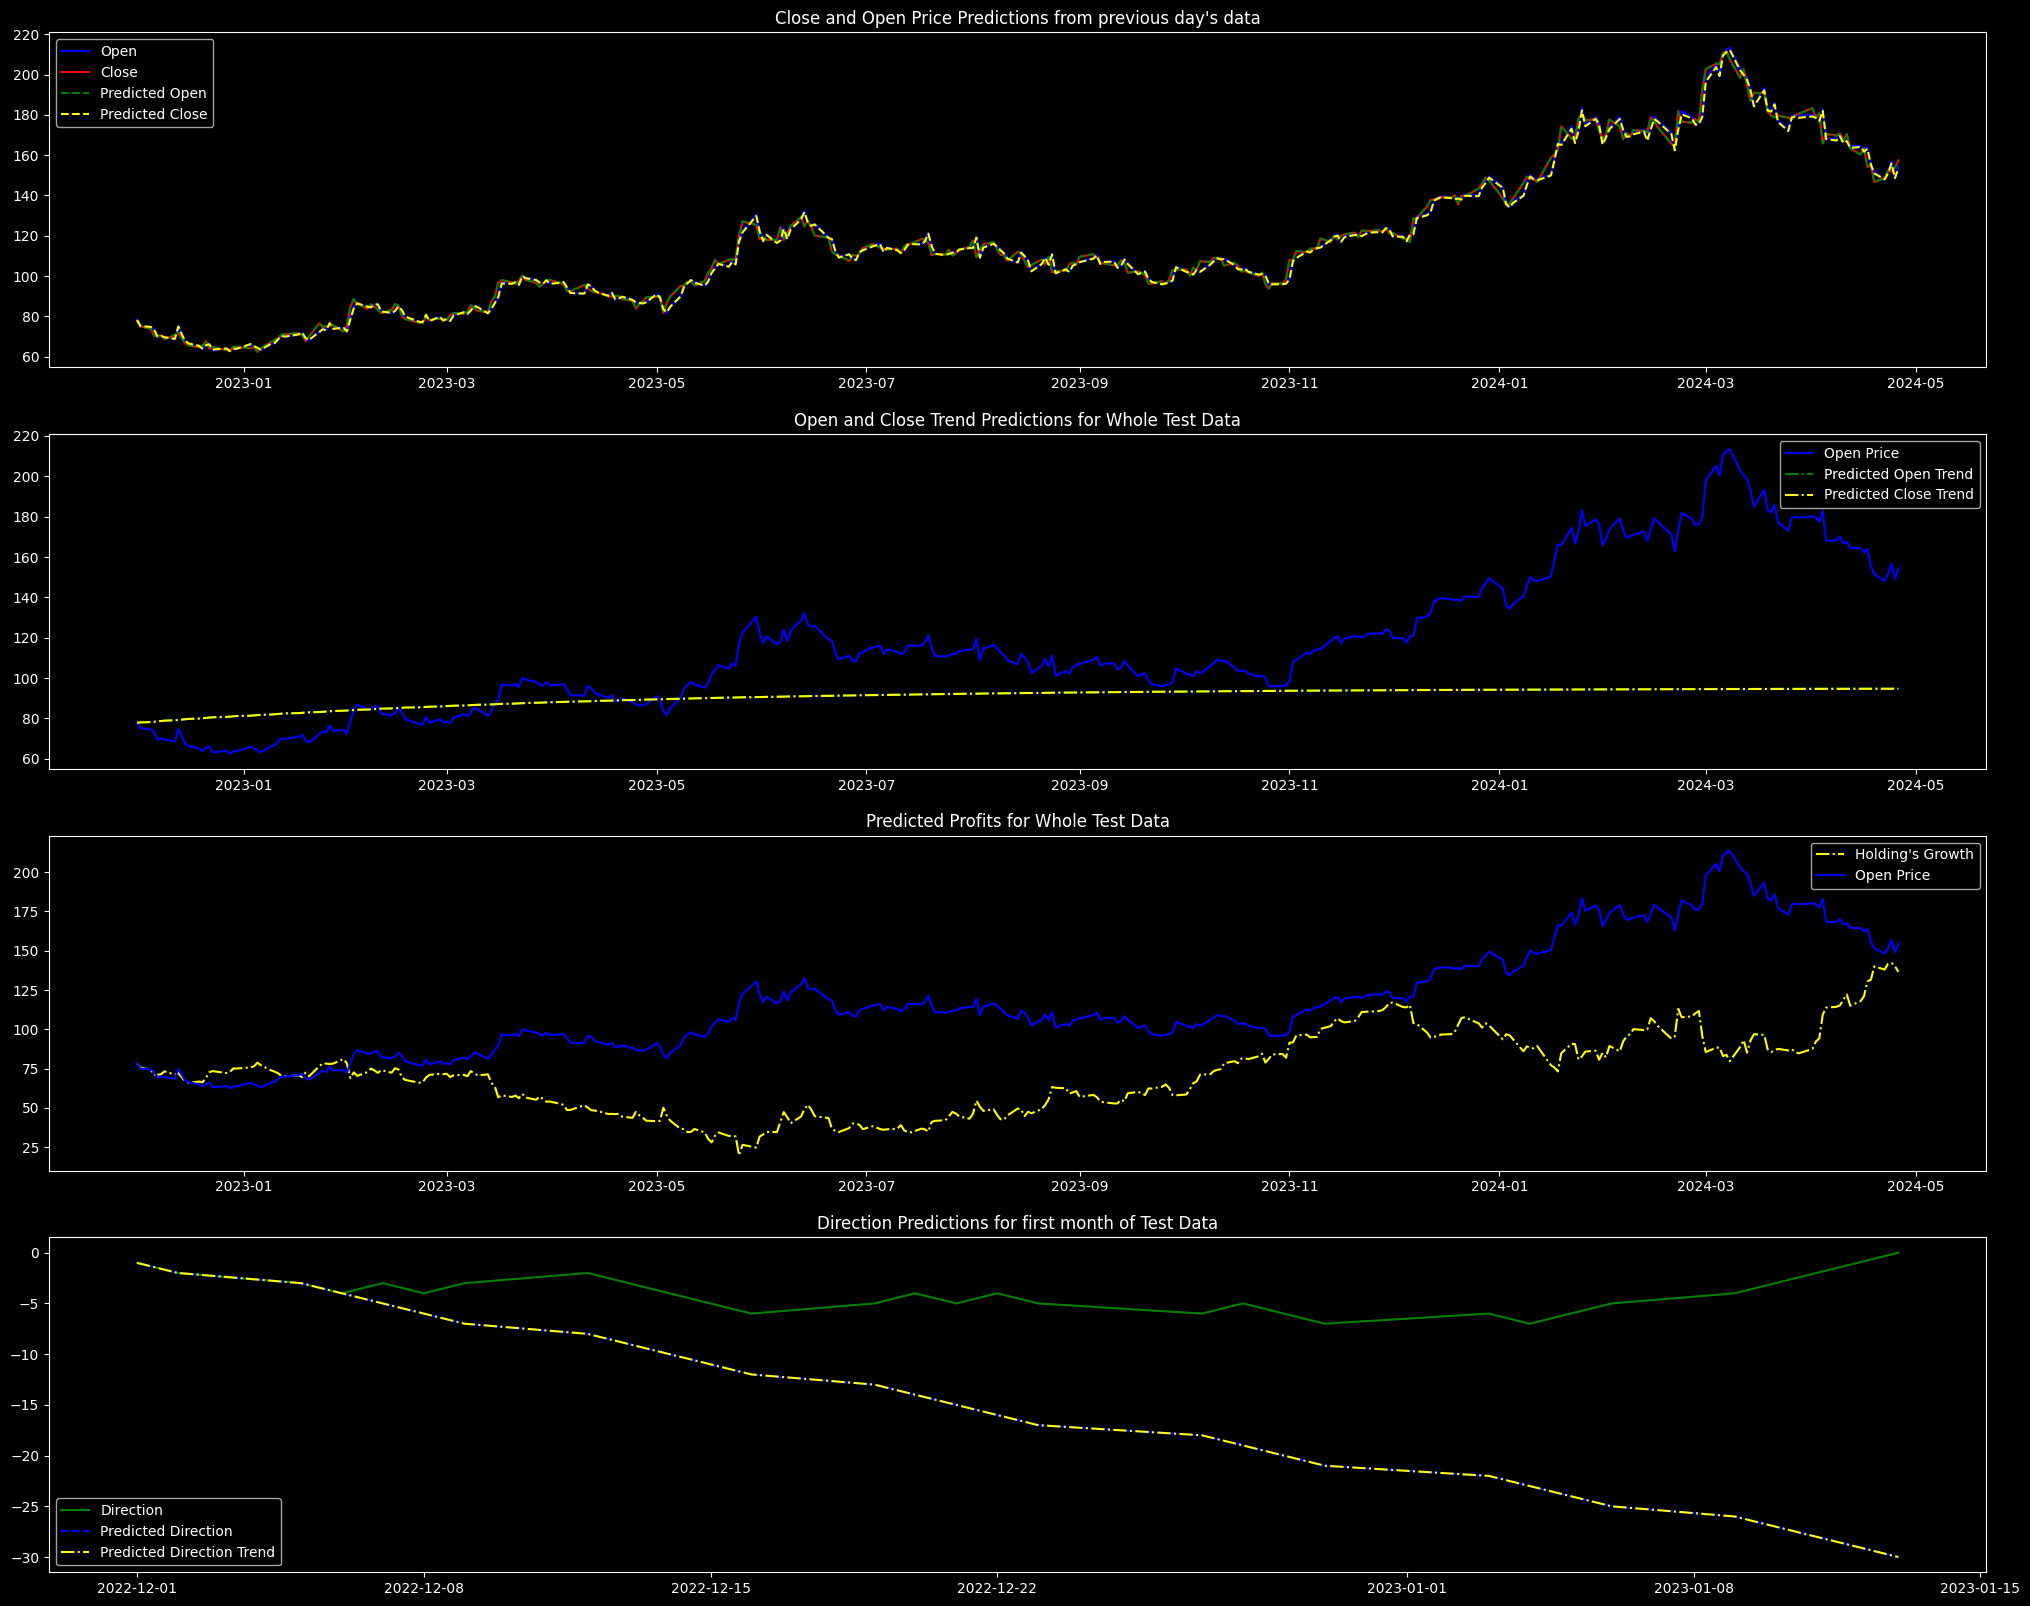

In [920]:
test.plot_train()
test.plot_test()

/========================================{ AMD }========================================\
                                    Close Predictions
----------------------------------------={ --- }=----------------------------------------

	|	Mean Absolute Error:		 29.677335648878376 		|

	|	Mean Squared Error:		 1732.57485332333 		|

	|	R2 Score:			 -0.3657390824410154 		|

	|	Rooted Absolute Error:		 5.447690854745557 		|

	|	Rooted Mean Squared Error:	 41.624209942332 		|

\========================================{ END }========================================/

/========================================{ AMD }========================================\
                                    Open Predictions
----------------------------------------={ --- }=----------------------------------------

	|	Mean Absolute Error:		 29.597529545359567 		|

	|	Mean Squared Error:		 1729.1849976717472 		|

	|	R2 Score:			 -0.35333006840275316 		|

	|	Rooted Absolute Error:		 5.440361159459872 		|

	|	Root

c:\Development\University\y2\t2\Machine Learning\group rpoject\Group-Project-ML\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Development\University\y2\t2\Machine Learning\group rpoject\Group-Project-ML\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Development\University\y2\t2\Machine Learning\group rpoject\Group-Project-ML\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predi

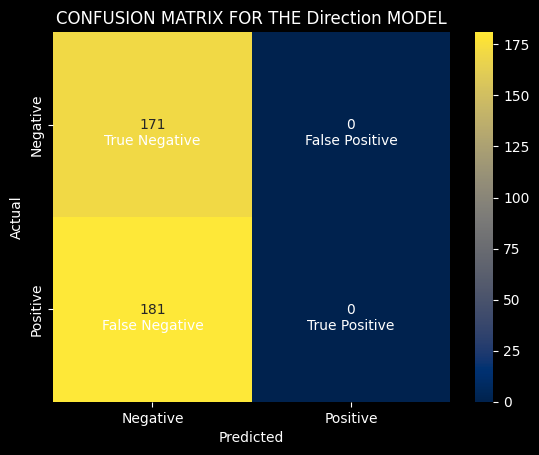

\========================================{ END }=========================================/

/========================================{ AMD }========================================\
                                    Whole Test Predictions
----------------------------------------={ --- }=----------------------------------------



Whole Test Predictions:
Whole Test Prediction Report:	
               precision    recall  f1-score   support

        -1.0       0.49      1.00      0.65       171
         1.0       0.00      0.00      0.00       181

    accuracy                           0.49       352
   macro avg       0.24      0.50      0.33       352
weighted avg       0.24      0.49      0.32       352



c:\Development\University\y2\t2\Machine Learning\group rpoject\Group-Project-ML\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Development\University\y2\t2\Machine Learning\group rpoject\Group-Project-ML\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Development\University\y2\t2\Machine Learning\group rpoject\Group-Project-ML\.venv\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predi

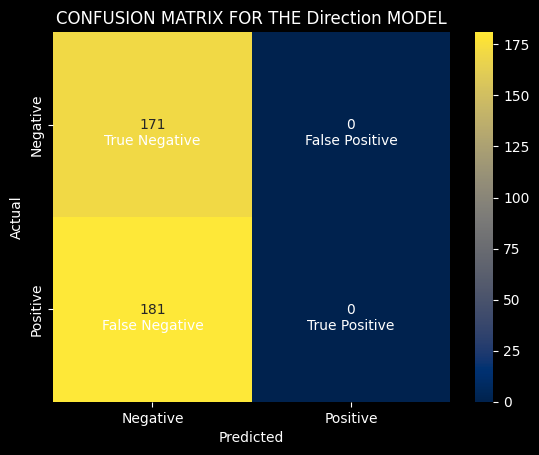

\========================================{ END }========================================/


In [921]:
test.evaluate()